In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xml.etree.ElementTree as ET
from PIL import Image
import shutil
import random

In [16]:
folder_path = "./dataset/annotations"
output_folder = "./dataset/processed"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        file_path = os.path.join(folder_path, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        image_folder = None
        image_filename = None
        objects = []
        
        # Find image folder, filename, and objects
        for elem in root.iter():
            if elem.tag == "folder":
                image_folder = elem.text
            elif elem.tag == "filename":
                image_filename = elem.text
            elif elem.tag == "object":
                obj = {}
                for sub_elem in elem:
                    obj[sub_elem.tag] = sub_elem.text
                    if sub_elem.tag == "bndbox":
                        bbox = {}
                        for bbox_elem in sub_elem:
                            bbox[bbox_elem.tag] = int(bbox_elem.text)
                        obj[sub_elem.tag] = bbox
                objects.append(obj)
        
        if image_folder is not None and image_filename is not None:
            # Construct full path to the image
            image_path = os.path.join('./dataset/', image_folder, image_filename)
            # Open the image using PIL
            image = Image.open(image_path)
            
            # Crop and save each object
            for obj in objects:
                name = obj.get("name")
                bndbox = obj.get("bndbox")
                xmin, ymin, xmax, ymax = bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]
                cropped_image = image.crop((xmin, ymin, xmax, ymax))
                cropped_image = cropped_image.resize((100,100))

                # Create a folder with the name if it doesn't exist
                output_obj_folder = os.path.join(output_folder, name)
                os.makedirs(output_obj_folder, exist_ok=True)
                # Save the cropped image
                cropped_image.save(os.path.join(output_obj_folder, f"{image_filename.split('.')[0]}_{name}.png"))


create separate train, test, validate folders

In [17]:
source_folder = "./dataset/processed"
train_folder = './dataset/train'
test_folder = './dataset/test'
validate_folder = './dataset/validate'

# Create destination folders if they don't exist
for folder in [train_folder, test_folder, validate_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Define the split ratio
train_split = 0.8
test_split = 0.1
validate_split = 0.1

max_stop_images_train = 25

# Iterate through each category folder
for category_folder in os.listdir(source_folder):
    category_path = os.path.join(source_folder, category_folder)
    if os.path.isdir(category_path):
        # Create category subfolders in train, test, and validate folders
        train_category_folder = os.path.join(train_folder, category_folder)
        test_category_folder = os.path.join(test_folder, category_folder)
        validate_category_folder = os.path.join(validate_folder, category_folder)
        for folder in [train_category_folder, test_category_folder, validate_category_folder]:
            if not os.path.exists(folder):
                os.makedirs(folder)
        # List all files in the category folder
        files = os.listdir(category_path)
        # Shuffle the files to ensure randomness
        random.shuffle(files)
        # Calculate split indices
        train_index = int(len(files) * train_split)
        test_index = int(len(files) * (train_split + test_split))
        # Divide the files into train, test, and validate sets
        train_files = files[:train_index]
        test_files = files[train_index:test_index]
        validate_files = files[test_index:]
        # Limit the number of images in the "stop" folder for training
        if category_folder == "stop":
            if len(train_files) > max_stop_images_train:
                additional_files = train_files[max_stop_images_train:]
                test_files.extend(additional_files[:len(additional_files) // 2])
                validate_files.extend(additional_files[len(additional_files) // 2:])
                train_files = train_files[:max_stop_images_train]
        # Move files to the corresponding category folders within train, test, and validate sets
        for file in train_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(train_category_folder, file))
        for file in test_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(test_category_folder, file))
        for file in validate_files:
            shutil.copy(os.path.join(category_path, file), os.path.join(validate_category_folder, file))

graph for total images in the 3 folders

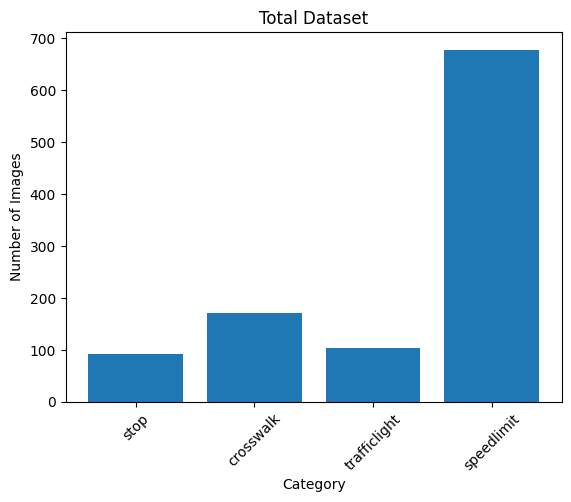

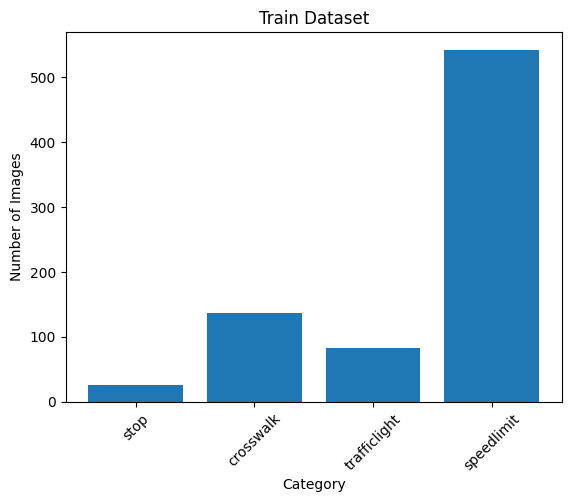

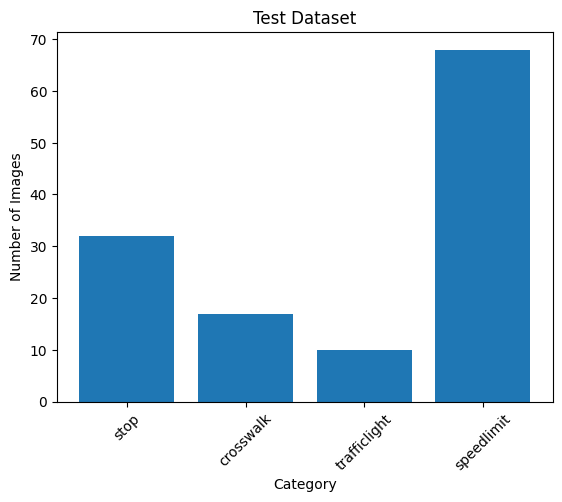

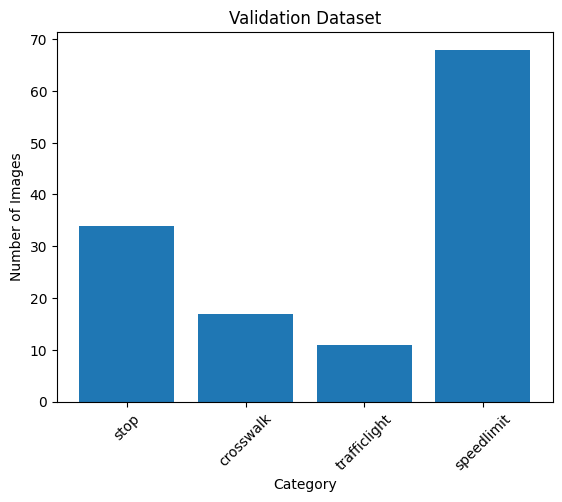

In [20]:
train_folder = './dataset/train'
test_folder = './dataset/test'
validate_folder = './dataset/validate'
total_folder  = './dataset/processed/'

# Function to count the total number of images in each category folder
def count_images(folder):
    categories = os.listdir(folder)
    category_counts = {}
    for category in categories:
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            category_counts[category] = num_images
    return category_counts

# Count the total number of images in each category for train, test, and validate folders
train_counts = count_images(train_folder)
test_counts = count_images(test_folder)
validate_counts = count_images(validate_folder)
total_count = count_images(total_folder)

# Plot graphs
def plot_graph(counts, title):
    categories = list(counts.keys())
    values = list(counts.values())
    plt.bar(categories, values)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_graph(total_count, 'Total Dataset')
plot_graph(train_counts, 'Train Dataset')
plot_graph(test_counts, 'Test Dataset')
plot_graph(validate_counts, 'Validation Dataset')